# <span style="color:STEELBLUE">**Set Up**</span>

## Import Libraries

In [12]:
import pandas as pd
import numpy as np
from numpy.fft import fft, fftfreq, ifft
import seaborn as sns
import matplotlib.pyplot as plt


## Import Data

Hourly Timestep \
Elevation NAVD88 \
Time GMT \
Units Meters

In [13]:
CHICK = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/02042500_Chick_Dichge_GH.xlsx")
df_CHICK = pd.DataFrame(CHICK)

CBBT = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638901_CBBT_season_combo.xlsx")
df_CBBT = pd.DataFrame(CBBT)

SP = pd.read_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638610_SP_season_combo.xlsx")
df_SP = pd.DataFrame(SP)

## Create Pandas Timestamps as DateTime Index

This creates a powerful date-time index that Pandas relies upon for time series functionality \
Declaring this will keep all timestamps consistent across all datasets \
We will also set the dataframe index to be the timestamp so that we can use Pandas time-based indexing functionality \
With this functionality, we can select slices of time intervals using .loc (inclusive of endpoints) --> df_CBBT.loc['2018-08-01':'2018-08-31']

In [14]:
df_CHICK['Timestamp'] = pd.to_datetime(df_CHICK['Time'])
df_CBBT['Timestamp'] = pd.to_datetime(df_CBBT['Time'])
df_SP['Timestamp'] = pd.to_datetime(df_SP['Time'])

In [15]:
#save a copy of timstamp as x for plotting?
x_SP = df_SP['Timestamp']
x_CBBT = df_CBBT['Timestamp']

In [16]:
df_CHICK = df_CHICK.set_index(['Timestamp'])
df_CBBT = df_CBBT.set_index(['Timestamp'])
df_SP = df_SP.set_index(['Timestamp'])

## Drop unnecesary columns

In [17]:
# print(df_SP.columns)
# print(df_CBBT.columns)
# print(df_CHICK.columns)

In [18]:
df_SP.drop(['Time', 'Date', 'Time_GMT', 'Date_ID', 'Time_ID', 'ID'], axis=1, inplace=True)
df_CBBT.drop(['Time', 'Date', 'Time_GMT', 'Date_ID', 'Time_ID', 'ID'], axis=1, inplace=True)
df_CHICK.drop(['Time', 'TIME_GMT', 'ID'], axis=1, inplace=True)

# <span style="color:STEELBLUE">**Fast Fourier Transform**</span>

Discrete Fourier transform separates its input into components that contribute at discrete frequencies \
Discretized input to the transform is customarily referred to as a signal, which exists in the time domain. The output is called a spectrum or transform and exists in the frequency domain.

### Discrete Fast Fourier Transform (DFFT)
![alt text](DFFT.png "Title") \
![alt text](SingleFreqComp.png "Title")

### Inverse DFFT 
![alt text](IDFFT.png "Title")

Method (https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/_) 

Calculate fast fourier transform of the total water level signal \
fft(a[, n, axis, norm])	Compute the one-dimensional discrete Fourier Transform.

In [19]:
fft_vals_SP = fft(df_SP['N_Obs_m'])

fft_vals_CBBT = fft(df_CBBT['N_Obs_m'])

### Power Spectral Density
![alt text](PSD.png "Title")

“How much power” is contained in the frequency interval between f and f C df \
Get the power spectral density by taking the square of the absolute value of fft_vals

In [20]:
psd_SP = np.abs(fft_vals_SP) ** 2

psd_CBBT = np.abs(fft_vals_CBBT) ** 2

Calculate the frequencies \
Day as frequency unit, aka frequency of 1 corresponsd to 1 day \
fftfreq(n[, d])	Return the Discrete Fourier Transform sample frequencies.

Frequency unit is the inverse of samping rate
so my samping rate is 1 per hour, 0.16666 per minute or 0.00027777 per second, 24 per day

In [248]:
freqs_SP = fftfreq(len(psd_SP), 1. / 24)
mask_SP = freqs_SP > 0

freqs_CBBT = fftfreq(len(psd_CBBT), 1. / 24 )
mask_CBBT = freqs_CBBT > 0

## Plots

In [249]:
y_SP = df_SP['N_Obs_m']
y_CBBT = df_CBBT['N_Obs_m']

In [250]:
sns.set(rc={'figure.figsize':(11, 4)})

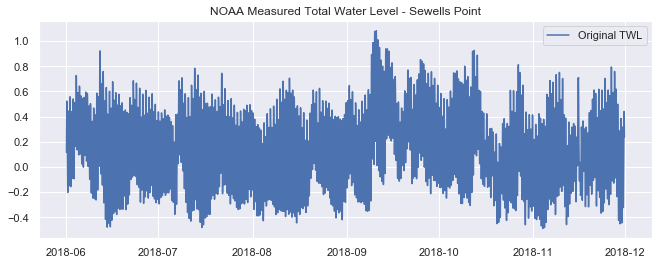

In [251]:
plt.figure(1)
plt.title ('NOAA Measured Total Water Level - Sewells Point')
plt.plot(x_SP, y_SP, label = 'Original TWL')
plt.legend()

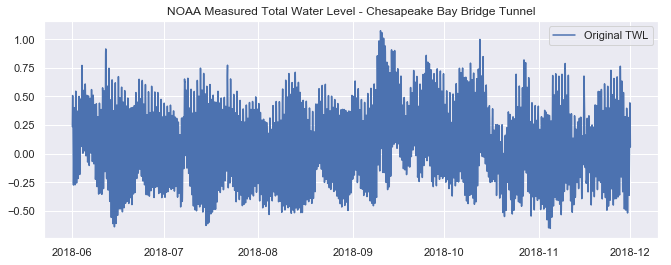

In [252]:
plt.figure(1)
plt.title ('NOAA Measured Total Water Level - Chesapeake Bay Bridge Tunnel')
plt.plot(x_CBBT, y_CBBT, label = 'Original TWL')
plt.legend()

Power spectral density of signal as a function of the frequency (in unit of 1/day), cycles per day \
Lograithmic scale for y axis (decibels)

Text(0,0.5,'PSD (dB)')

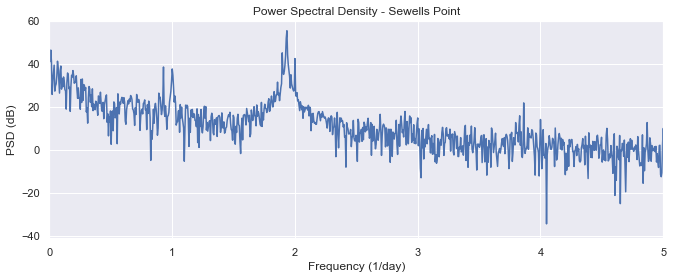

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(freqs_SP[mask_SP], 10 * np.log10(psd_SP[mask_SP]))
plt.title ('Power Spectral Density - Sewells Point')
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel('PSD (dB)')


Text(0,0.5,'PSD (dB)')

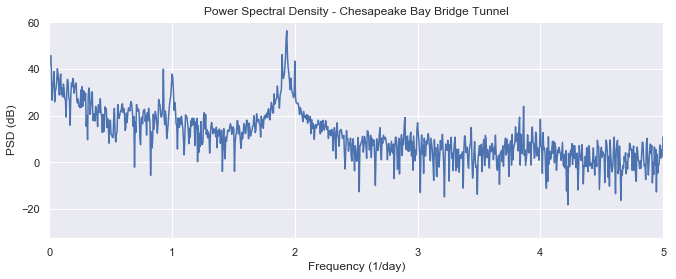

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(freqs_CBBT[mask_CBBT], 10 * np.log10(psd_CBBT[mask_CBBT]))
plt.title ('Power Spectral Density - Chesapeake Bay Bridge Tunnel')
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/day)')
ax.set_ylabel('PSD (dB)')

Cut out frequencies higher than the fundemental frequency using the daily frequency measure

In [197]:
fft_bis_SP = fft_vals_SP.copy()
fft_bis_SP[np.abs(freqs_SP) > 1.89] = 0

fft_bis_CBBT = fft_vals_CBBT.copy()
fft_bis_CBBT[np.abs(freqs_CBBT) > 1.89] = 0

ifft(a[, n, axis, norm])	Compute the one-dimensional inverse discrete Fourier Transform.

In [198]:
detide_SP = np.real(ifft(fft_bis_SP))

detide_CBBT = np.real(ifft(fft_bis_CBBT))


In [199]:
# plt.figure(1)
# plt.title ('NOAA Measured Total Water Level')
# plt.plot(x, y, label = 'Original TWL')
# plt.legend()

Text(0,0.5,'Water Level (m)')

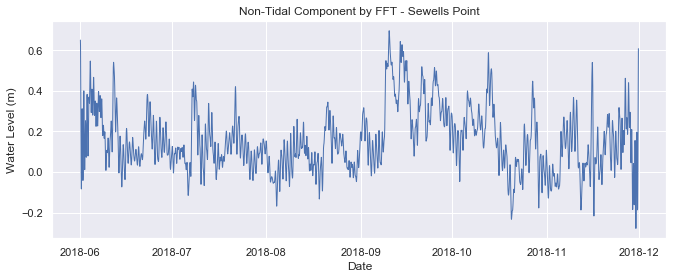

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(x_SP, detide_SP, linewidth = 1)
ax.set_title('Non-Tidal Component by FFT - Sewells Point')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level (m)')

Text(0,0.5,'Water Level (m)')

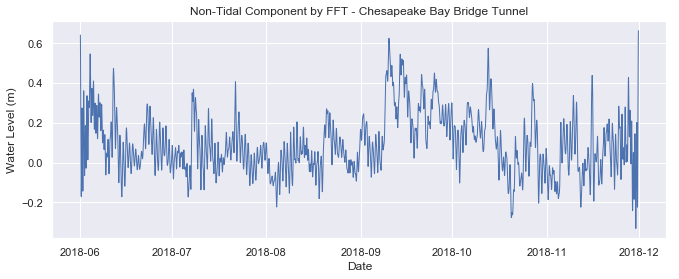

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(x_CBBT, detide_CBBT, linewidth = 1)
ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel')
ax.set_xlabel('Date')
ax.set_ylabel('Water Level (m)')

## Add manual FFT detiding to original dataframe

In [202]:
df_SP['man_detide'] = detide_SP

df_CBBT['man_detide'] = detide_CBBT

## Export

In [203]:
# df_SP.to_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638610_SP_season_combo_FFT.xlsx")

# df_CBBT.to_excel("/Users/lszczyrba/Project_3.6.3/Tides/Data/8638901_CBBT_season_combo_FFT.xlsx")

# <span style="color:STEELBLUE">**Figures - Non-Tidal Residuals**</span>


Test out different figures we can make

In [204]:
sns.set(rc={'figure.figsize':(11, 4)})


## Individual line plots

In [205]:
# df_SP['T_NTR_m'].plot(linewidth=0.5);

In [206]:
# df_SP['N_Obs_min_Pred_m'].plot(linewidth=0.5);

## Subplots using dots as markers

In [207]:
# cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m']
# axes = df_SP[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
# for ax in axes:
#     ax.set_ylabel('Water Elevation (m)')

## Subplots using lines as markers

### Sewells Point

Text(0.05,0.5,'Water Elevation (m)')

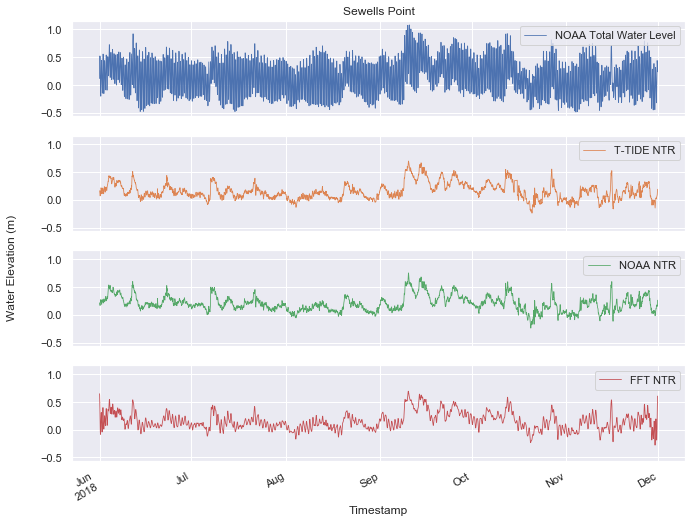

In [208]:
cols_plot = ['N_Obs_m','T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_SP[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = True, sharex = True)

axes[0].legend(['NOAA Total Water Level'])
axes[1].legend(['T-TIDE NTR'])
axes[2].legend(['NOAA NTR'])
axes[3].legend(['FFT NTR'])

axes[0].set_title('Sewells Point')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)



### Chesapeake Bay Bridge Tunnel

Text(0.05,0.5,'Water Elevation (m)')

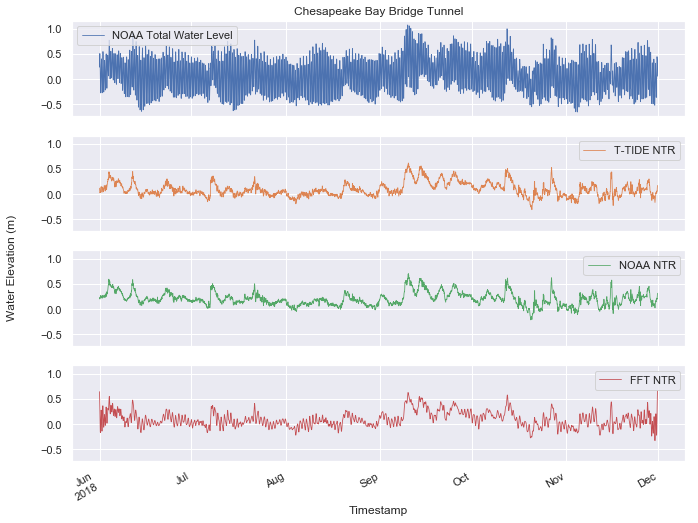

In [209]:
cols_plot = ['N_Obs_m','T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
axes = df_CBBT[cols_plot].plot(linewidth=0.8, figsize=(11, 9), subplots=True, sharey = True, sharex = True)

axes[0].legend(['NOAA Total Water Level'])
axes[1].legend(['T-TIDE NTR'])
axes[2].legend(['NOAA NTR'])
axes[3].legend(['FFT NTR'])

axes[0].set_title('Chesapeake Bay Bridge Tunnel')

fig = axes[0].figure
fig.text(0.05,0.5, 'Water Elevation (m)', ha="center", va="center", rotation=90)

## Comparing 2 datasets on one column, looking at just Hurricane Michael Timeframe

### Sewell's Point

In [210]:
# cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m']
# ax = df_SP[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
# ax.set_ylabel('Water Elevation (m)')

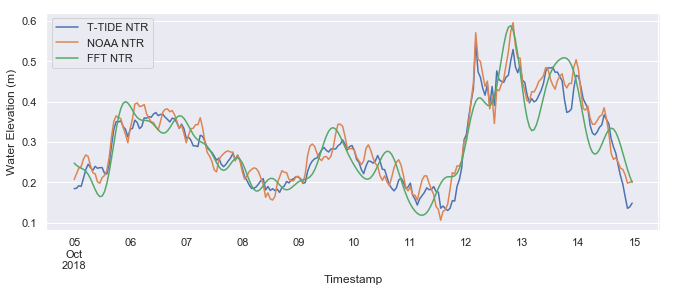

In [211]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_SP[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])

### Chesapeake Bay Bridge Tunnel

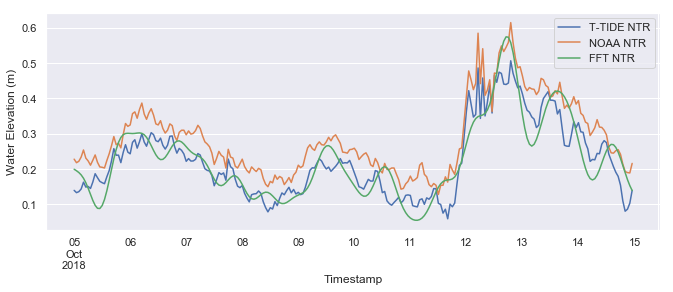

In [212]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_CBBT[cols_plot].loc['2018-10-05':'2018-10-14'].plot(linestyle='-')
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])

## Same plot looking at whole season

### Sewells Point

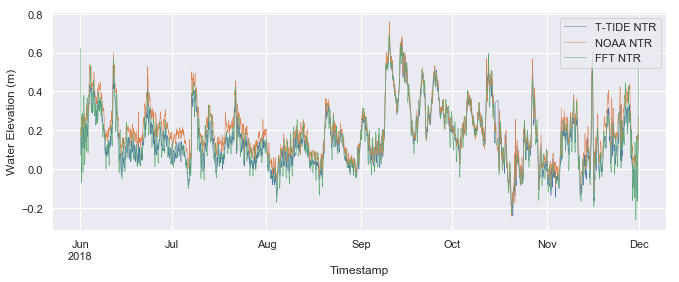

In [164]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_SP[cols_plot].plot(linestyle='-', linewidth=0.5)
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])

### Chespeake Bay Bridge Tunnel

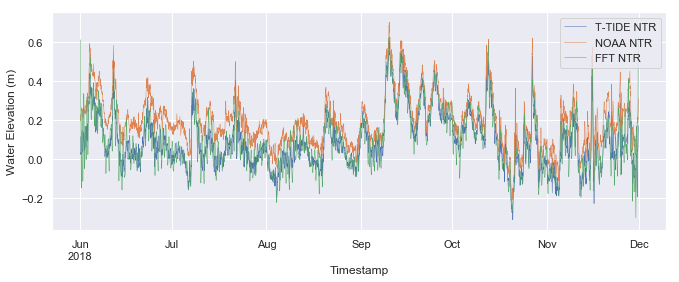

In [165]:
cols_plot = ['T_NTR_m', 'N_Obs_min_Pred_m', 'man_detide']
ax = df_CBBT[cols_plot].plot(linestyle='-', linewidth=0.5)
ax.set_ylabel('Water Elevation (m)')
ax.legend(['T-TIDE NTR','NOAA NTR','FFT NTR'])